# A synthetic DC/IP model
## Overview
Tina yesterday suggested a synthetic model that is kind of a mix inspired by both the Mjölkalunga (sediments) and Odarslöv (Dike). We have three main layers:
* 2 metres of dry sand
* 8 metres of saturated sand (aquifer)
* clay basement
plus two anomalies:
* a (silty?) block in the sand
* a near-vertical dyke

Assume a Terrameter LS2 measurement with 81 electrodes using the multiple-gradient array.

![Model](model.png)

In [2]:
# We first import the needed modules
import numpy as np
import pygimli as pg
import pygimli.meshtools as mt  # submodule of pg
from pygimli.physics import ert  # subsubmodule

## The synthetic model
### The data scheme
We start with the data, creating a multi-gradient data with 81 electrodes, compute the geometric factors and display it. Note that the vertical axis does not refer to a pseudodepth but is a logical arrangement of data points so that every data is represented by a block of equal size, here of a Schlumberger (sl) type data. The data consist of four blocks with potential electrode distances of 1, 3, 5 and 7. One oblique line represents data with the same AB bipole.

In [3]:
scheme = ert.createData(elecs=81, schemeName="gr")
print(scheme)

Data: Sensors: 81 data: 1260, nonzero entries: ['a', 'b', 'm', 'n', 'valid']


(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1ecab8df520>)

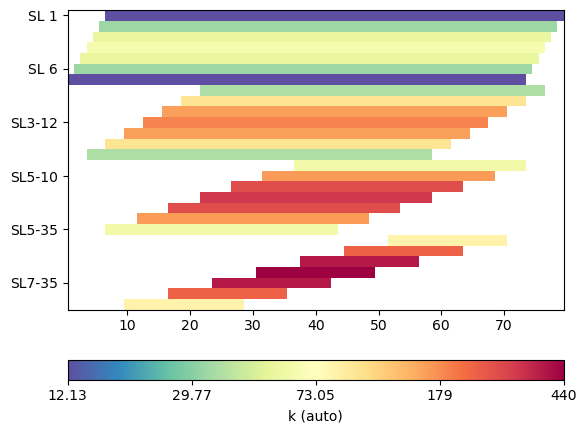

In [4]:
scheme["k"] = ert.geometricFactors(scheme)
ert.show(scheme, "k")

## The model geometry
As next step, we build up the synthetic model starting with the function `createWorld` to create a box, into which layers are inserted. Next, we will create arectangular anomaly, and finally a dike, which will explain us the region markers a little bit.

(<Axes: >, None)

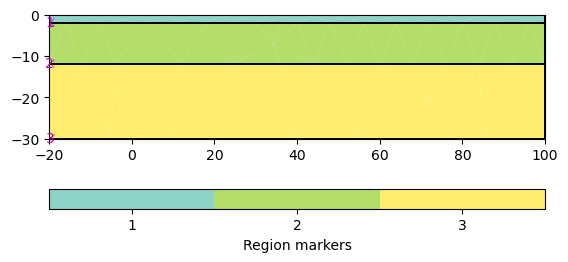

In [10]:
world = mt.createWorld(start=[-20, -30], end=[100, 0], layers=[-2, -12])
pg.show(world)

Text(0, 0.5, 'z in m')

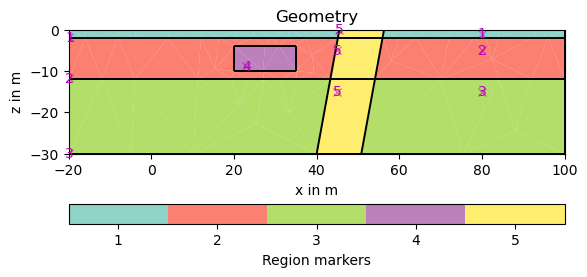

In [40]:
ano = mt.createRectangle(start=[20, -10], end=[35, -4], marker=4)
points = [[45.5, 0], [56.3, 0], [50.8, -30], [40, -30]]
dike = mt.createPolygon(points, isClosed=True, marker=5)
geo = world + ano + dike
geo.addRegionMarker([45, -5], marker=5)
geo.addRegionMarker([45, -15], marker=5)
geo.addRegionMarker([80, -1], marker=1)
geo.addRegionMarker([80, -5], marker=2)
geo.addRegionMarker([80, -15], marker=3)
ax, cb = pg.show(geo)
ax.set_title("Geometry")
ax.set_xlabel("x in m")
ax.set_ylabel("z in m")

We add the electrode as nodes to the geometry to ensure sufficient accuracy, and create a mesh of the model. Then we populate the model with resistivities by using a map.

In [42]:
for sen in scheme.sensors():
    geo.createNode(sen)
    geo.createNode(sen+[0.5, 0])

Now we create a mesh

(<Axes: >, None)

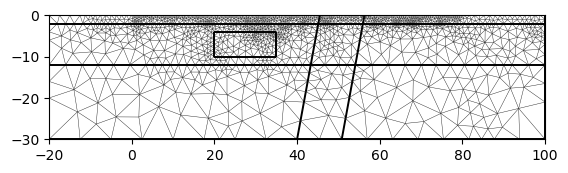

In [43]:
mesh = mt.createMesh(geo, quality=34.3)
pg.show(mesh)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1ecf0f9a7f0>)

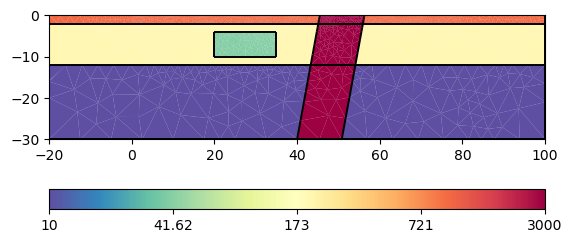

In [47]:
# pg.show(mesh, markers=True, showMesh=True)
rhoMap = [[1, 1000], [2, 200], [3, 10], [4, 40], [5, 3000]]  # marker, resistivity
pg.show(mesh, rhoMap, cMap="Spectral_r", logScale=True)

## The forward modelling
We simply call the `simulate` function of the ERT module, passing the mesh, the data scheme, and the resistivity map. Additionally we provide a noise level for estimating an error and generating Gaussian noise that is added to the data.

Data error estimate (min:max)  0.030000373633076845 : 0.03296175466774962
Data: Sensors: 81 data: 1260, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']


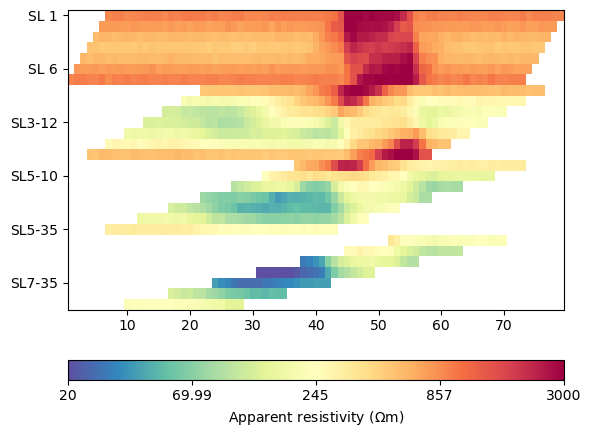

In [61]:
data = ert.simulate(mesh, scheme, rhoMap, noiseLevel=0.03)
print(data)
ax, cb = ert.show(data, cMin=20, cMax=3000)

## DC Inversion
We use the ERT manager class passing the data. The inversion is only another simple one-liner to which we can pass any options for mesh, regularization or inversion. We will play with the regularization parameter, the vertical weight, or we might use geostatistical regularization.

In [78]:
mgr = ert.Manager(data)
mgr.invert(quality=34.4, zWeight=0.2, verbose=True)

07/06/23 - 11:29:46 - pyGIMLi - INFO - Found 2 regions.
07/06/23 - 11:29:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/06/23 - 11:29:46 - pyGIMLi - INFO - Found 2 regions.
07/06/23 - 11:29:46 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/06/23 - 11:29:46 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/06/23 - 11:29:46 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/06/23 - 11:29:46 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5383 Cells: 10328 Boundaries: 7964
07/06/23 - 11:29:46 - pyGIMLi - INFO - Use median(data values)=516.9186793069431
07/06/23 - 11:29:46 - pyGIMLi - INFO - Created startmodel from forward operator: 1976 [516.9186793069431,...,516.9186793069431]
07/06/23 - 11:29:46 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001ECF8747810>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001ECF8747A90>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001ECF872C7C0>
min/max (data): 13.86/3354
min/max (error): 3%/3.3%
min/max (start model): 517/517
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 64.83 (dPhi = 94.71%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 19.45 (dPhi = 69.77%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 7.71 (dPhi = 59.68%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.15 (dPhi = 81.87%) lam: 20.0
--------------------------------------

1976 [934.5092713085319,...,12.0198334870946]

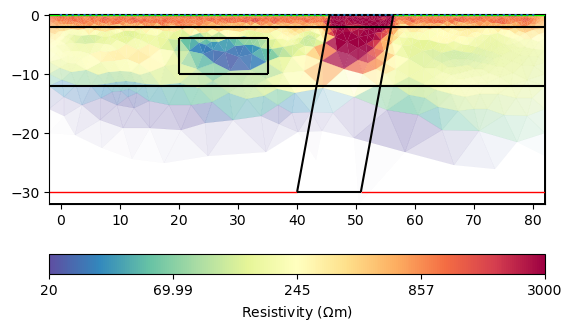

In [80]:
ax, cb = mgr.showResult(cMin=20, cMax=3000)
pg.viewer.mpl.drawPLC(ax, geo, fillRegion=False, fitView=False)

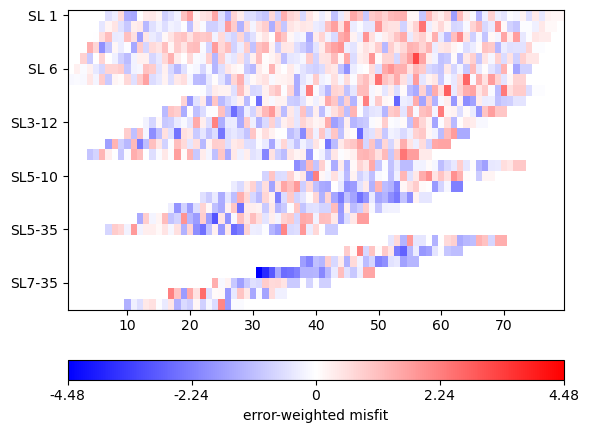

In [79]:
mgr.showMisfit(True)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1ecf834d490>)

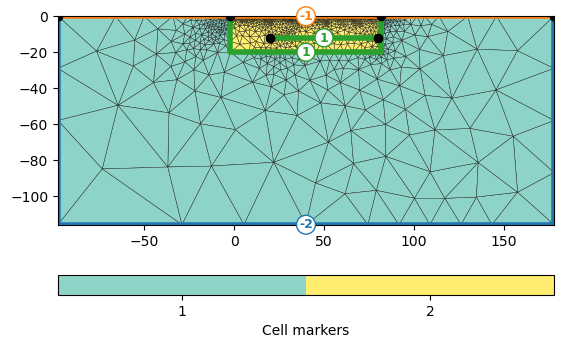

In [88]:
plc = mt.createParaMeshPLC(data, paraDepth=20, boundary=1.2)
plc += mt.createLine(start=[20, -12], end=[80, -12], marker=1)
# pg.show(plc)
invmesh = mt.createMesh(plc, quality=34.3)
pg.show(invmesh, markers=True, showMesh=True)

In [90]:
mgr.invert(mesh=invmesh, verbose=True)

07/06/23 - 11:39:09 - pyGIMLi - INFO - Found 2 regions.
07/06/23 - 11:39:09 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/06/23 - 11:39:09 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/06/23 - 11:39:09 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/06/23 - 11:39:09 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 5038 Cells: 9652 Boundaries: 7450
07/06/23 - 11:39:09 - pyGIMLi - INFO - Use median(data values)=516.9186793069431
07/06/23 - 11:39:09 - pyGIMLi - INFO - Created startmodel from forward operator: 1841 [516.9186793069431,...,516.9186793069431]
07/06/23 - 11:39:09 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001ECF8747810>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001ECF8747A90>
Model transformation (cumulative):
	 0 <pgcore._pygimli_.RTransLogLU object at 0x000001ECF870D280>
min/max (data): 13.86/3354
min/max (error): 3%/3.3%
min/max (start model): 517/517
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 47.08 (dPhi = 95.89%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 27.17 (dPhi = 40.88%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 19.05 (dPhi = 28.27%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 14.92 (dPhi = 20.14%) lam: 20.0
------------------------------------

1841 [1.986156118243184,...,35.364839816583185]

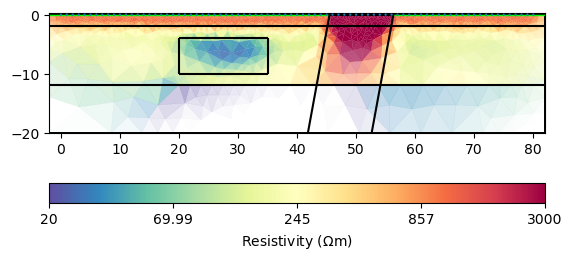

In [93]:
ax, cb = mgr.showResult(cMin=20, cMax=3000)
pg.viewer.mpl.drawPLC(ax, geo, fillRegion=False, fitView=False)

07/06/23 - 12:01:05 - pyGIMLi - INFO - Found 2 regions.
07/06/23 - 12:01:05 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/06/23 - 12:01:05 - pyGIMLi - INFO - Found 2 regions.
07/06/23 - 12:01:05 - pyGIMLi - INFO - (ERTModelling) Region with smallest marker (1) set to background.
07/06/23 - 12:01:05 - pyGIMLi - INFO - Creating forward mesh from region infos.
07/06/23 - 12:01:05 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.
07/06/23 - 12:01:05 - pyGIMLi - INFO - Mesh for forward task: Mesh: Nodes: 3369 Cells: 6328 Boundaries: 4950
07/06/23 - 12:01:05 - pyGIMLi - INFO - Use median(data values)=516.9186793069431
07/06/23 - 12:01:05 - pyGIMLi - INFO - Created startmodel from forward operator: 1318 [516.9186793069431,...,516.9186793069431]
07/06/23 - 12:01:05 - pyGIMLi - INFO - Starting inversion.


fop: <pygimli.physics.ert.ertModelling.ERTModelling object at 0x000001ECF9A313B0>
Data transformation: <pgcore._pygimli_.RTransLogLU object at 0x000001ECF9A314F0>
Model transformation: <pgcore._pygimli_.RTransLog object at 0x000001ECF9A31450>
min/max (data): 13.86/3354
min/max (error): 3%/3.3%
min/max (start model): 517/517
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
inv.iter 1 ... chi² = 78.13 (dPhi = 93.55%) lam: 20
--------------------------------------------------------------------------------
inv.iter 2 ... chi² = 9.54 (dPhi = 86.37%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 3 ... chi² = 1.45 (dPhi = 70.23%) lam: 20.0
--------------------------------------------------------------------------------
inv.iter 4 ... chi² = 1.33 (dPhi = 6.5%) lam: 20.0
------------------------------------------------------------

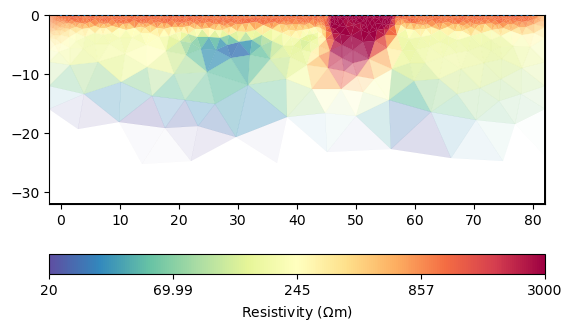

In [103]:
mgr = ert.Manager(data)
# mgr.inv.setRegularization(correlationLengths=[20, 3])
mgr.inv.setRegularization(2, correlationLengths=[10, 3], dip=110)
mgr.invert(verbose=True)
ax, cb = mgr.showResult(cMin=20, cMax=3000)
